<a href="https://www.kaggle.com/code/iahhel/sentiment-analysis-using-vader-and-roberta?scriptVersionId=129770197" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# The purpose of this project is to conduct a sentiment analysis on tweets related to the 2022 World Cup using two different approaches: the Vader sentiment analysis tool and a pre-trained Roberta model from Hugging Face. This analysis aims to identify the overall sentiment of the tweets related to the World Cup, such as positive, negative or neutral, which could provide insights into how people feel about the event.

In [1]:
# !pip install gdown
# !pip install transformers
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from nltk import download, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
# download(['punkt','vader_lexicon'])

In [2]:
df = pd.read_csv('/kaggle/input/fifa-world-cup-2022-tweets/fifa_world_cup_2022_tweets.csv') # Source: Kaggle.com
df.drop('Unnamed: 0',axis=1, inplace=True)
print('2022 Fifa worldcup tweets dataset with the shape of',df.shape)
df.sample(5)

2022 Fifa worldcup tweets dataset with the shape of (22524, 5)


,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
9880,2022-11-20 16:08:07+00:00,0,Twitter Web App,Has anyone else realised that pretty much all ...,neutral
2341,2022-11-20 18:09:03+00:00,0,Twitter for iPhone,"Ecuador 2, Qatar 0. What are our thoughts?? #W...",neutral
7403,2022-11-20 16:12:19+00:00,2,Twitter for Android,The suspicion over the ref gets bigger after E...,negative
9093,2022-11-20 16:09:11+00:00,0,Twitter for iPhone,How was that offside? #WorldCup2022,neutral
6812,2022-11-20 16:15:51+00:00,0,Twitter for iPhone,VAR referee is called Massimiliano Irrati…sure...,neutral


As we can see its already labeled so we can compare our results with the Sentiment column.

negative    5784
neutral     8251
positive    8489
Name: Sentiment, dtype: int64


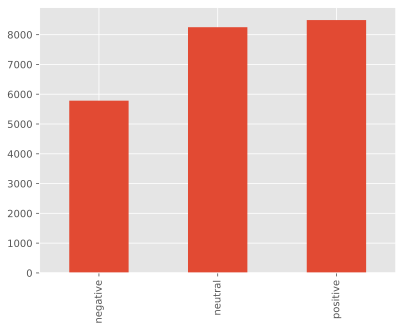

In [3]:
print(df['Sentiment'].value_counts().sort_index())
df['Sentiment'].value_counts().sort_index().plot(kind='bar')
plt.show()

In [4]:
# using regex to clean the tweets, removing usernames, urls, stopwords, etc.
def preprocess(text):
    text = re.sub(r'(^|\s)@(\w+)', r'\1@user', text)
    text = re.sub(r'\bhttps?://\S+\b', 'http', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(tokens)
    return text

In [5]:
df['preprocessed_tweet'] = df['Tweet'].apply(preprocess)

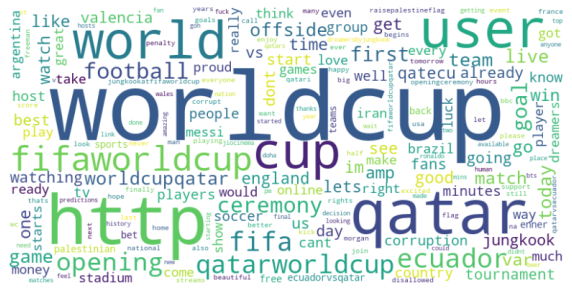

In [6]:
# Calculate word frequencies
word_freq = df['preprocessed_tweet'].str.split().explode().value_counts().reset_index()
word_freq.columns = ['Word', 'Frequency']
word_freq['Frequency'] = word_freq['Frequency'].astype(int)  # Convert frequency column to integers

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq.set_index('Word')['Frequency'].to_dict())

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
sia = SentimentIntensityAnalyzer()

res = [sia.polarity_scores(row['preprocessed_tweet']) for _, row in df.iterrows()]

In [8]:
sentclassify = []
for i in range(len(res)):
    review = res[i]
    # Check if the 'compound' attribute of the review is greater than or equal to 0.05
    if review['compound'] >= 0.05:
        # If the review is positive, append "positive" to the sentclassify list
        sentclassify.append("positive")
    # Check if the 'compound' attribute of the review is less than or equal to -0.05
    elif review['compound'] <= -0.05:
        # If the review is negative, append "negative" to the sentclassify list
        sentclassify.append("negative")
    # If the review is neither positive nor negative, append "neutral" to the sentclassify list
    else:
        sentclassify.append("neutral")

In [9]:
vader = pd.DataFrame(sentclassify)
df['vader'] = vader
df.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet,vader
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral,drinking today user user user user worldcup http,neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive,amazing user worldcup launch video shows much ...,positive
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive,worth reading watching worldcup http,positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive,golden maknae shinning bright http jeonjungkoo...,positive
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative,bbc cares much human rights homosexual rights ...,neutral


In [10]:
df.Tweet[4]

'If the BBC cares so much about human rights, homosexual rights, and women rights then why not say these before the opening ceremony?? Why are they saying these during the opening ceremony?? Why did the BBC censor the #WorldCup2022 opening ceremony?? https://t.co/f72P03ZN2k'

One of the cons of vaders is that it doesn't understand relations between the words, for instance we have sarcastic phrases.

now i am going to go with roberta, a pre-trained model which has been trained on 58m tweets.

In [11]:
robertahuggingface = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(robertahuggingface)
tokenizer = AutoTokenizer.from_pretrained(robertahuggingface)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [12]:
def polarity_scores_roberta(Input):
    # Tokenize the input text using the tokenizer
    encoded_text = tokenizer(Input, return_tensors='pt')
    # Pass the tokenized input to the model and get the output
    output = model(**encoded_text)
    # Extract the scores from the output and convert it to a NumPy array
    scores = output[0][0].detach().numpy()
    # Apply softmax on the scores to normalize them
    scores = softmax(scores)
    # Return the normalized scores
    return scores

In [13]:
df2 = df.head(500) # using only 500 observations for the roberta model otherwise it'll take forever to finish.
res = []
for i, row in tqdm(df2.iterrows(), total=len(df2)): 
  text= row['Tweet']
  res.append(polarity_scores_roberta(text))

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
roberta = []
for i in range(len(res)):
  argmax = np.argmax(res[i])
  if argmax == 0:
    roberta.append('negative')
  elif argmax == 1:
    roberta.append('neutral')
  else:
    roberta.append('positive')
df2['roberta'] = roberta
df2.sample(10)

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,preprocessed_tweet,vader,roberta
483,2022-11-20 22:28:10+00:00,3,Tweetbot for iΟS,"He drinks no whiskey drink, he drinks no vodka...",positive,drinks whiskey drink drinks vodka drink drinks...,positive,neutral
109,2022-11-20 23:23:03+00:00,0,Triberr,Love sexy #soccer players? Grab your #FREE #fo...,positive,love sexy soccer players grab free football er...,positive,positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive,golden maknae shinning bright http jeonjungkoo...,positive,positive
211,2022-11-20 23:06:21+00:00,4,Twitter for iPhone,YMA O HYD 🏴󠁧󠁢󠁷󠁬󠁳󠁿 \nTomorrow!!! 😬 \nIt feels l...,positive,yma hyd tomorrow feels like christmas eve time...,positive,positive
257,2022-11-20 22:59:21+00:00,0,Twitter Web App,QATAR : #WorldCup2022 : Qatar 0 Vs 2 Ecuador\n...,negative,qatar worldcup qatar vs ecuador world cup kick...,negative,negative
350,2022-11-20 22:45:00+00:00,0,TweetDeck,It's the second of this week's #OddsOnPodcast'...,neutral,second weeks oddsonpodcasts show discuss world...,neutral,neutral
388,2022-11-20 22:41:17+00:00,0,Twitter for Android,Who do you think will win the #WorldCup2022 🥱\...,neutral,think win worldcup qatar qatarworldcup fifawor...,positive,neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive,amazing user worldcup launch video shows much ...,positive,positive
494,2022-11-20 22:26:11+00:00,2,Twitter Web App,We discuss the #England Selection made by Gare...,neutral,discuss england selection made gareth southgat...,positive,neutral
416,2022-11-20 22:37:17+00:00,2,Twitter for Android,This one was so fun !!!!! #WorldCup2022 https:...,positive,one fun worldcup http,positive,positive


In [15]:
print('sentiment column\n',df2['Sentiment'].value_counts().sort_index(),'\n---')
print('vader model prediction\n',df2['vader'].value_counts().sort_index(),'\n---')
print('roberta model prediction\n',df2['roberta'].value_counts().sort_index())

sentiment column
 negative    126
neutral     201
positive    173
Name: Sentiment, dtype: int64 
---
vader model prediction
 negative    109
neutral     157
positive    234
Name: vader, dtype: int64 
---
roberta model prediction
 negative    127
neutral     219
positive    154
Name: roberta, dtype: int64
